## Import Modules

In [52]:
import os
import shutil
from datetime import datetime

from PIL import Image
import pandas
import numpy

import matplotlib.pyplot as plt
import seaborn


from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Data Preparation Part 1 (creating the csv)

### numpy.dot example

In [4]:
numpy.dot((100,100,100), [0.5, 0.2, 0.1])

80.0

In [5]:
seaborn.set(rc = {"figure.figsize":(12,10)})

### Rename all images with flower type 

```python
directories = ["/users/danielcorcoran/desktop/flowers/daisy/",
              "/users/danielcorcoran/desktop/flowers/tulip/",
              "/users/danielcorcoran/desktop/flowers/sunflower/",
              "/users/danielcorcoran/desktop/flowers/dandelion/",
              "/users/danielcorcoran/desktop/flowers/rose/"]
```

```python 

for directory in directories:

    flower_type = directory.split("/")[-2]
    
    for filename in os.listdir(directory):
        
        print(flower_type, filename)
        os.rename(directory+filename, directory+flower_type +"_" + filename)
        
```

### Create Dataframe containing all flower image data

In [6]:
directory_path = "/users/danielcorcoran/desktop/flowers/all_flowers/"

In [7]:
dataset = pandas.DataFrame()

In [8]:
counter = 0

for filename in os.listdir(directory_path):
    
    filepath = directory_path + filename
    if ".jpg" in filename:
        image = Image.open(filepath)
        size = image.size
        width = int(image.size[0])
        height = int(image.size[1])
        size = str(width) + "x" + str(height)
        category = filename.split("_")[0]
        
        dataset.loc[counter, "file_name"] = filename
        dataset.loc[counter, "file_path"] = directory_path
        dataset.loc[counter, "width"] = width
        dataset.loc[counter, "height"] = height
        dataset.loc[counter, "size"] = size
        dataset.loc[counter, "flower_type"] = category
        
        counter = counter + 1

In [9]:
grouped = dataset.groupby("size").count()
grouped.sort_values(by = "file_name", ascending = False).head()

,file_name,file_path,width,height,flower_type
size,,,,,
320x240,604,604,604,604,604


### Create subset containing only 320x240 images

In [10]:
data320x240 = dataset[dataset["size"] == "320x240"]

### Reset index

In [11]:
data320x240.reset_index(drop = True, inplace = True)

In [12]:
data320x240.head(3)

,file_name,file_path,width,height,size,flower_type
0,daisy_144099102_bf63a41e4f_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,daisy
1,tulip_4612075317_91eefff68c_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,tulip
2,daisy_2578695910_5ab8ee17c1_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,daisy


In [13]:
data320x240["full_path"] = data320x240["file_path"] + data320x240["file_name"]

In [14]:
data320x240.head(3)

,file_name,file_path,width,height,size,flower_type,full_path
0,daisy_144099102_bf63a41e4f_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,daisy,/users/danielcorcoran/desktop/flowers/all_flow...
1,tulip_4612075317_91eefff68c_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,tulip,/users/danielcorcoran/desktop/flowers/all_flow...
2,daisy_2578695910_5ab8ee17c1_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,daisy,/users/danielcorcoran/desktop/flowers/all_flow...


## Data Preparation Part 2 (for model)

### Feature engineering
Collect RGB features 

### A function used to map greyscales to pixel tuples returned by Image.getdata

In [17]:
def get_greyscale(pixel_tuple):
    
    # multiplier for grey scale value obtained from link below:
    # https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
    
    grey_scale_value = numpy.dot(pixel_tuple, [0.299, 0.587, 0.114])
    
    return grey_scale_value

### A function to generate a PIL.Image object and generate list of greyscale values given a path to an image

In [18]:
def get_image_data(path):
    
    image = Image.open(path)
    pixels = list(image.getdata())
    
    grey_scale_value = list(map(get_greyscale, pixels))

    return grey_scale_value

In [19]:
start = datetime.now()

data320x240["image_data_mapped"] = data320x240["full_path"].map(get_image_data)

print("Finished in: {}".format(datetime.now() - start))

Finished in: 0:02:02.687237


In [20]:
data320x240.head()

,file_name,file_path,width,height,size,flower_type,full_path,image_data_mapped
0,daisy_144099102_bf63a41e4f_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,daisy,/users/danielcorcoran/desktop/flowers/all_flow...,"[67.82799999999999, 24.820999999999998, 20.918..."
1,tulip_4612075317_91eefff68c_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,tulip,/users/danielcorcoran/desktop/flowers/all_flow...,"[121.82300000000001, 132.782, 139.891, 147.927..."
2,daisy_2578695910_5ab8ee17c1_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,daisy,/users/danielcorcoran/desktop/flowers/all_flow...,"[135.16099999999997, 129.64499999999998, 127.1..."
3,rose_5721768347_2ec4d2247b_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,rose,/users/danielcorcoran/desktop/flowers/all_flow...,"[168.986, 168.102, 166.84199999999998, 167.906..."
4,daisy_8709110478_60d12efcd4_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,daisy,/users/danielcorcoran/desktop/flowers/all_flow...,"[27.942, 29.11, 28.061, 22.115, 11.838, 6.191,..."


### Create new dataframe splitting image_data_mapped lists into multiple columns

In [21]:
expanded_data = data320x240["image_data_mapped"].apply(pandas.Series)

In [22]:
expanded_data.head()

,0,1,2,3,4,5,6,7,8,9,...,76790,76791,76792,76793,76794,76795,76796,76797,76798,76799
0,67.828,24.821,20.918,7.288,21.882,5.288,36.226,18.146,12.164,64.061,...,42.014,20.937,30.693,62.717,51.857,47.047,30.899,45.376,55.236,13.098
1,121.823,132.782,139.891,147.927,148.160,142.145,150.974,166.122,171.847,172.097,...,80.267,75.093,77.839,94.357,42.965,61.316,71.882,74.250,92.211,74.657
2,135.161,129.645,127.129,132.445,139.832,141.843,135.125,128.347,123.297,126.936,...,123.006,124.006,121.718,122.718,122.718,123.718,123.718,124.718,124.718,125.718
3,168.986,168.102,166.842,167.907,164.995,156.089,144.209,134.121,131.915,129.872,...,187.890,186.249,192.726,187.840,186.709,187.866,179.838,166.169,159.717,162.233
4,27.942,29.110,28.061,22.115,11.838,6.191,12.208,22.094,19.143,17.143,...,31.813,35.058,35.792,36.710,38.041,37.910,35.149,29.872,23.231,18.573


### Join split data onto original dataframe

In [23]:
full_data = pandas.concat([data320x240, expanded_data], axis = 1)

In [24]:
full_data.head()

,file_name,file_path,width,height,size,flower_type,full_path,image_data_mapped,0,1,...,76790,76791,76792,76793,76794,76795,76796,76797,76798,76799
0,daisy_144099102_bf63a41e4f_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,daisy,/users/danielcorcoran/desktop/flowers/all_flow...,"[67.82799999999999, 24.820999999999998, 20.918...",67.828,24.821,...,42.014,20.937,30.693,62.717,51.857,47.047,30.899,45.376,55.236,13.098
1,tulip_4612075317_91eefff68c_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,tulip,/users/danielcorcoran/desktop/flowers/all_flow...,"[121.82300000000001, 132.782, 139.891, 147.927...",121.823,132.782,...,80.267,75.093,77.839,94.357,42.965,61.316,71.882,74.250,92.211,74.657
2,daisy_2578695910_5ab8ee17c1_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,daisy,/users/danielcorcoran/desktop/flowers/all_flow...,"[135.16099999999997, 129.64499999999998, 127.1...",135.161,129.645,...,123.006,124.006,121.718,122.718,122.718,123.718,123.718,124.718,124.718,125.718
3,rose_5721768347_2ec4d2247b_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,rose,/users/danielcorcoran/desktop/flowers/all_flow...,"[168.986, 168.102, 166.84199999999998, 167.906...",168.986,168.102,...,187.890,186.249,192.726,187.840,186.709,187.866,179.838,166.169,159.717,162.233
4,daisy_8709110478_60d12efcd4_n.jpg,/users/danielcorcoran/desktop/flowers/all_flow...,320.0,240.0,320x240,daisy,/users/danielcorcoran/desktop/flowers/all_flow...,"[27.942, 29.11, 28.061, 22.115, 11.838, 6.191,...",27.942,29.110,...,31.813,35.058,35.792,36.710,38.041,37.910,35.149,29.872,23.231,18.573


In [25]:
full_data.to_csv("/users/danielcorcoran/desktop/flowers/flowers_320x240_data_final.csv", 
                 index_label= "row_index")

### Read in data 

In [26]:
data = pandas.read_csv("/users/danielcorcoran/desktop/flowers/flowers_320x240_data_final.csv")

In [27]:
columns = list(data.columns)

In [28]:
columns

['row_index',
 'file_name',
 'file_path',
 'width',
 'height',
 'size',
 'flower_type',
 'full_path',
 'image_data_mapped',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '

In [30]:
X = data.drop(['row_index',
 'file_name',
 'file_path',
 'width',
 'height',
 'size',
 'flower_type',
 'full_path',
 'image_data_mapped'], axis = 1)

y = data["flower_type"]

In [31]:
X.shape

(604, 76800)

In [32]:
y.shape

(604,)

In [33]:
y.unique()

array(['daisy', 'tulip', 'rose', 'sunflower', 'dandelion'], dtype=object)

In [34]:
mapping = {
    "daisy":0,
    "tulip":1,
    "rose":2,
    "sunflower":3,
    "dandelion":4
}

In [35]:
y_numeric = y.replace(mapping)

## Modelling

### Import sklearn

In [83]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

### Instantiate the model

In [84]:
pca = PCA(svd_solver='randomized', 
          n_components = 4,
          whiten = True, 
          random_state = 42)

svc = SVC(kernel = "rbf", 
          class_weight = "balanced")

model = make_pipeline(pca, 
                      svc)

### Split target vector and feature matrix into train and test subsets

In [85]:
Xtrain, Xtest, ytrain, ytest  = train_test_split(X, #flowers feature matrix
                                                 y_numeric, #flowers target matrix
                                                 random_state = 42,
                                                 test_size = 0.5)

### Fit the model

In [86]:
param_grid = {"svc__C": [1, 5, 10, 50],
             "svc__gamma":[0.0001, 0.0005, 0.001, 0.005, 0.0075, 0.01]}

grid = GridSearchCV(model, param_grid)
%time grid.fit(Xtrain, ytrain)

print(grid.best_params_)

CPU times: user 2min 15s, sys: 47.2 s, total: 3min 2s
Wall time: 1min 6s
{'svc__C': 50, 'svc__gamma': 0.01}


### Predict using model built with test data

In [87]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

### Check Accuracy

In [88]:
accuracy_score(yfit, ytest)

0.3609271523178808

### Generate Classification report

In [89]:
report = classification_report(ytest, 
                            yfit, 
                            target_names = mapping.keys())

print(report)

             precision    recall  f1-score   support

      daisy       0.29      0.46      0.36        50
      tulip       0.32      0.44      0.37        61
       rose       0.44      0.16      0.24        50
  sunflower       0.46      0.44      0.45        77
  dandelion       0.36      0.27      0.31        64

avg / total       0.38      0.36      0.35       302



Text(88,0.5,'Predicted label')

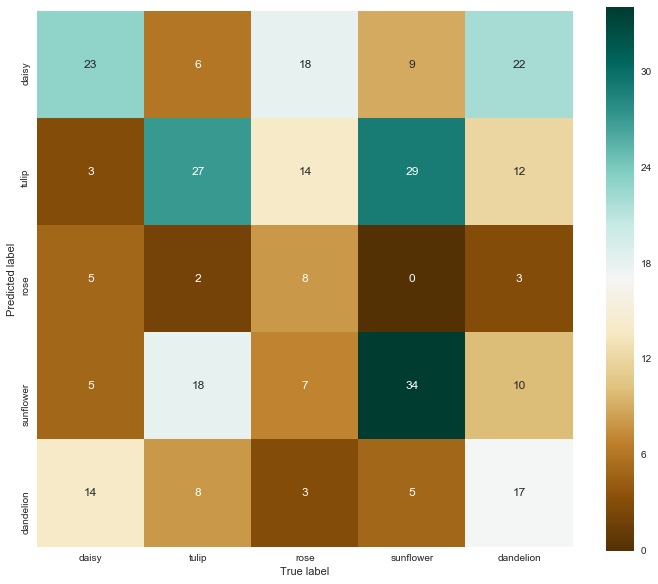

In [90]:
mat = confusion_matrix(ytest, yfit)

seaborn.heatmap(mat.T, 
                square = True, 
                annot = True, 
                fmt = "d", 
                cmap = "BrBG",
               xticklabels = mapping.keys(),
               yticklabels = mapping.keys())

plt.xlabel("True label")
plt.ylabel("Predicted label")